<a href="https://colab.research.google.com/github/MK316/Teachingapps/blob/main/ControlNet_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Reference: Control net on colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/controlnet.ipynb)

In [2]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00


To process different conditionings depending on the chosen ControlNet, we also need to install some 
additional dependencies:
- [OpenCV](https://opencv.org/)
- [controlnet-aux](https://github.com/patrickvonplaten/controlnet_aux#controlnet-auxiliary-models) - a simple collection of pre-processing models for ControlNet

In [3]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 4.0 MB/s eta 0:00:00


image from url

https://github.com/MK316/Spring2023/raw/main/data/monarisa.png

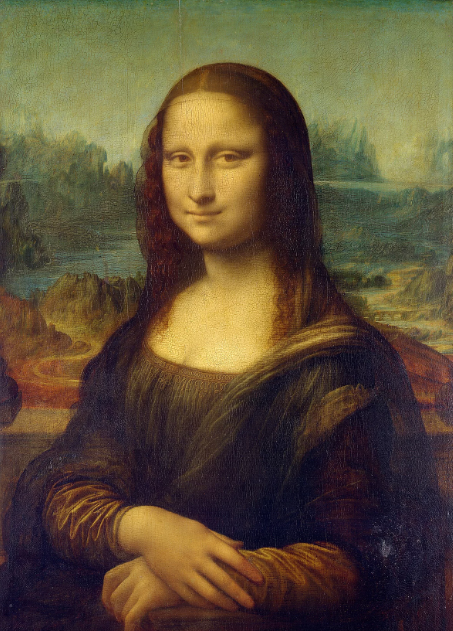

In [4]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image("https://github.com/MK316/Spring2023/raw/main/data/monarisa.png")
image

Next, we will put the image through the canny pre-processor:

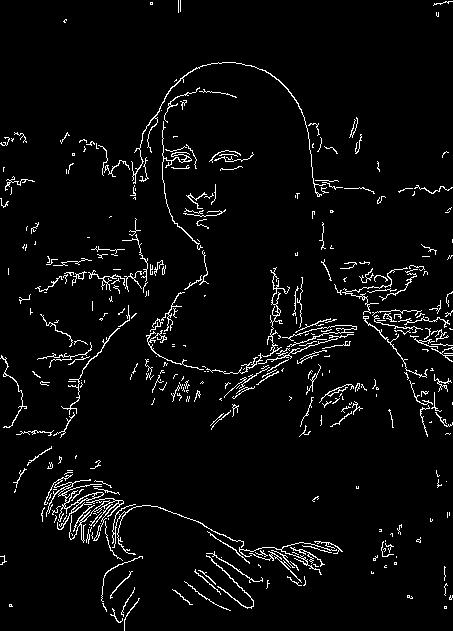

In [5]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

As we can see, it is essentially edge detection.

Now, we load runwaylml/stable-diffusion-v1-5 as well as the ControlNet model for canny edges. The models are loaded in half-precision (torch.dtype) to allow for fast and memory-efficient inference.

In [6]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Instead of using Stable Diffusion's default [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm), we use one of the currently fastest 
diffusion model schedulers, called [UniPCMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/unipc).
Choosing an improved scheduler can drastically reduce inference time - in our case we are able to reduce the number of inference steps from 50 to 20 while more or less 
keeping the same image generation quality. More information regarding schedulers can be found [here](https://huggingface.co/docs/diffusers/main/en/using-diffusers/schedulers).

In [7]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

Instead of loading our pipeline directly to GPU, we instead enable smart CPU offloading which 
can be achieved with the [`enable_model_cpu_offload` function](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/controlnet#diffusers.StableDiffusionControlNetPipeline.enable_model_cpu_offload).

Remember that during inference diffusion models, such as Stable Diffusion require not just one but multiple model components that are run sequentially.
In the case of Stable Diffusion with ControlNet, we first use the CLIP text encoder, then the diffusion model unet and control net, then the VAE decoder and finally run a safety checker.
Most components are only run once during the diffusion process and are thus not required to occupy GPU memory all the time. By enabling smart model offloading, we make sure 
that each component is only loaded into GPU when it's needed so that we can significantly save memory consumption without significantly slowing down infenence.

**Note**: When running `enable_model_cpu_offload`, do not manually move the pipeline to GPU with `.to("cuda")` - once CPU offloading is enabled, the pipeline automatically takes care of GPU memory management.

In [8]:
pipe.enable_model_cpu_offload()

Finally, we want to take full advantage of the amazing [FlashAttention/xformers](https://github.com/facebookresearch/xformers) attention layer acceleration, so let's enable this! If this command does not work for you, you might not have `xformers` correctly installed.
In this case, you can just skip the following line of code.

In [9]:
pipe.enable_xformers_memory_efficient_attention()

Now we are ready to run the ControlNet pipeline!

We still provide a prompt to guide the image generation process, just like what we would normally do with a Stable Diffusion image-to-image pipeline. However, ControlNet will allow a lot more control over the generated image because we will be able to control the exact composition in generated image with the canny edge image we just created.

It will be fun to see some images where contemporary celebrities posing for this exact same painting from the 17th century. And it's really easy to do that with ControlNet, all we have to do is to include the names of these celebrities in the prompt!

  0%|          | 0/20 [00:00<?, ?it/s]

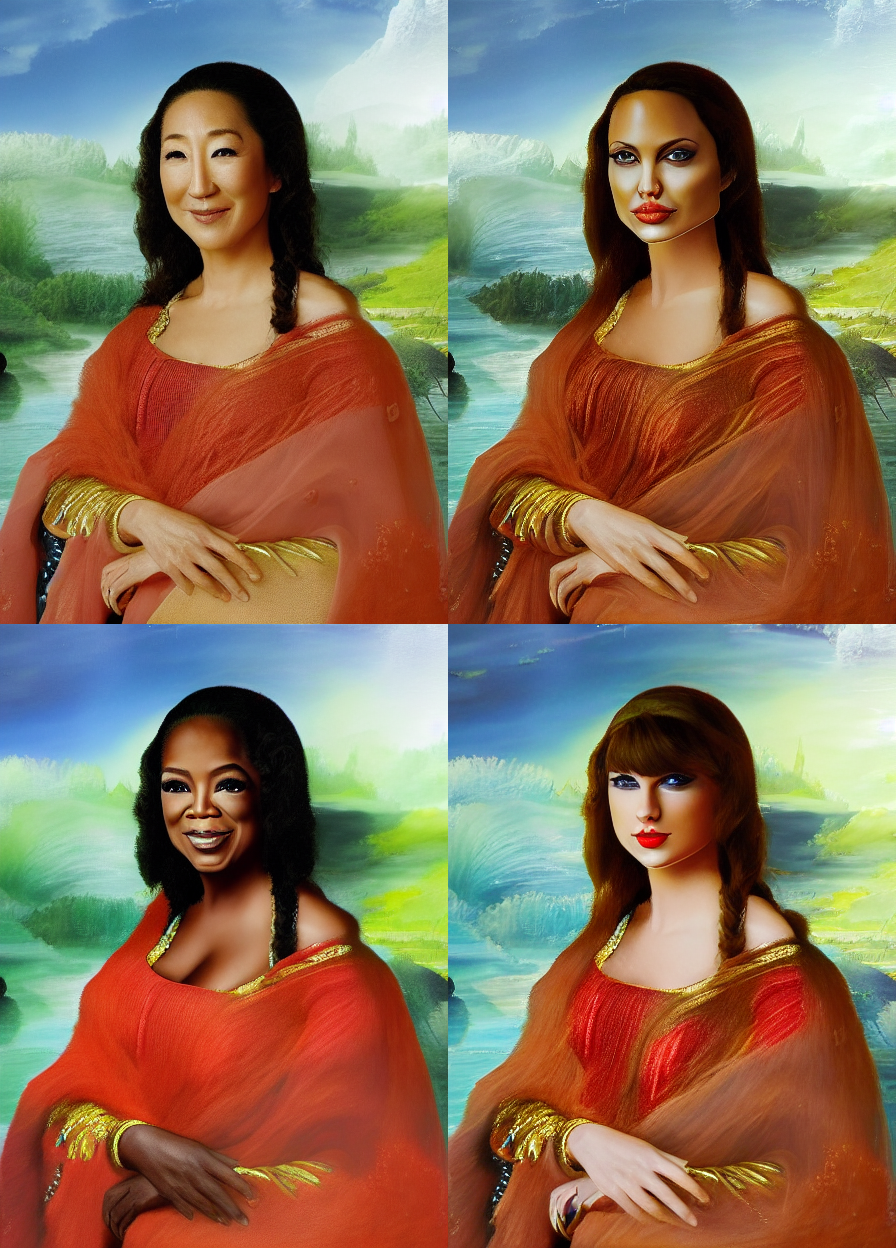

In [21]:
#@markdown Image grid with known celebrities
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

prompt = ", best quality, extremely detailed"
MK = "/content/sample1.png"
prompt = [t + prompt for t in ["Sandra Oh", "Angelina Jolie", "Oprah Winfrey", "taylor swift"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=20,
)

image_grid(output.images, 2, 2)

We can effortlessly combine ControlNet combines with fine-tuning too! For example, we can fine-tune a model with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth), and use it to render ourselves into different scenes.

In this post, we are going to use our beloved Mr Potato Head as an example to show how to use ControlNet with DreamBooth.

We can use the same ContrlNet, however instead of using the Stable Diffusion 1.5, we are going to load the [Mr Potato Head model](https://huggingface.co/sd-dreambooth-library/mr-potato-head) into our pipeline - Mr Potato Head is a Stable Diffusion model fine-tuned with Mr Potato Head concept using Dreambooth 🥔

Let's run the above commands again, keeping the same `controlnet` though!

In [ ]:
model_id = "sd-dreambooth-library/mr-potato-head"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Now let's make Mr Potato posing for [Johannes Vermeer](https://en.wikipedia.org/wiki/Johannes_Vermeer)!

In [1]:
generator = torch.manual_seed(2)
prompt = "a photo of sks mr potato head, best quality, extremely detailed"
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, lowres, bad anatomy, worst quality, low quality",
    generator=generator,
    num_inference_steps=20,
)

NameError: ignored

It is noticeable that Mr Potato Head is not the best candidate but he tried his best and did a pretty good job in capture some of the essence 🍟

In [ ]:
output.images[0]